In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
df_train = pd.read_csv("beijing.csv", encoding='iso-8859-1', low_memory = False)
df_test = pd.read_csv("test.csv", encoding='iso-8859-1', low_memory = False)

In [2]:
df_train.drop(['url','id'],axis=1,inplace = True)#删除URL和id两列
df_train.drop(['DOM'],axis=1,inplace = True) #缺失值过多 直接删去该列


url：获取数据的url              
id：交易的id              
Lng：坐标 
Lat：坐标             
Cid：社区id              
tradeTime：交易时间              
DOM：活动日市场。              
followers：跟踪交易的人数。              
totalPrice：总价              
price：按平方计算的平均价格              
square：房子的面积             
livingRoom：客厅的数量              
drawingRoom：图纸室的数量             
kitchen：厨房的数量              
bathroom：浴室数量              
floor：房屋的高度。              
buildingType：包括塔（1）、平房（2）、板塔结合（3）、板（4）。              
constructionTime：施工时间              
renovationCondition：装修情况 包括其他（1）、粗糙（2）、简约（3）、精装（4）              
buildingStructure：建筑结构：包括未知（1）、混合（2）、砖木（3）、砖混（4）、钢（5）、钢-混凝土组合（6）。              
ladderRati梯比：同层居民人数与电梯数量的比例。它描述了一个居民平均有多少个电梯。  
elevator 有电梯（1）或没有电梯（0）              
fiveYearsPropert：五年产权  
subway：有（1）或没有（0）  
district：区域  
communityAverage：社区平均值  

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255081 entries, 0 to 255080
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Lng                  255081 non-null  float64
 1   Lat                  255081 non-null  float64
 2   Cid                  255081 non-null  int64  
 3   tradeTime            255081 non-null  object 
 4   followers            255081 non-null  int64  
 5   totalPrice           255081 non-null  float64
 6   price                255081 non-null  int64  
 7   square               255081 non-null  float64
 8   livingRoom           255081 non-null  object 
 9   drawingRoom          255081 non-null  object 
 10  kitchen              255081 non-null  int64  
 11  bathRoom             255081 non-null  object 
 12  floor                255081 non-null  object 
 13  buildingType         253445 non-null  float64
 14  constructionTime     255081 non-null  object 
 15  renovationConditi

In [4]:
df_train.dropna(subset=['elevator','subway','buildingType','fiveYearsProperty'], axis = 0, inplace = True)#删去这四列有缺失值的行
df_train['communityAverage'].fillna(df_train['communityAverage'].mean(), inplace=True)

In [5]:
df_train['tradeTime'] = pd.to_datetime(df_train['tradeTime'])
df_train['year'] = df_train['tradeTime'].dt.year#将交易时间的数据类型转为int
df_train['month'] = df_train['tradeTime'].dt.month#将交易时间的数据类型转为int
df_train.drop(df_train[df_train['year']  < 2012].index, inplace = True)
df_train.drop(df_train[df_train['year']  > 2017].index, inplace = True)#只取2012-2017年的数据 删去其他不具代表性的少量数据
df_train.drop(['tradeTime'],axis=1,inplace = True) 

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248316 entries, 0 to 255080
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Lng                  248316 non-null  float64
 1   Lat                  248316 non-null  float64
 2   Cid                  248316 non-null  int64  
 3   followers            248316 non-null  int64  
 4   totalPrice           248316 non-null  float64
 5   price                248316 non-null  int64  
 6   square               248316 non-null  float64
 7   livingRoom           248316 non-null  object 
 8   drawingRoom          248316 non-null  object 
 9   kitchen              248316 non-null  int64  
 10  bathRoom             248316 non-null  object 
 11  floor                248316 non-null  object 
 12  buildingType         248316 non-null  float64
 13  constructionTime     248316 non-null  object 
 14  renovationCondition  248316 non-null  int64  
 15  buildingStructure

In [7]:
df_train['floor'] = df_train['floor'].str.extract(r'([0-9]+)')
df_train['floor'] = df_train['floor'].astype('int64')
df_train['constructionTime'] = df_train['constructionTime'].str.extract(r'([0-9]+)')
df_train['constructionTime'].fillna(2004, inplace=True)#用最多的值填充
df_train['constructionTime'] = df_train['constructionTime'].astype('int64')

In [8]:
df_train['livingRoom'] = df_train['livingRoom'].astype('int64')
df_train['drawingRoom'] = df_train['drawingRoom'].astype('int64')
df_train['bathRoom'] = df_train['bathRoom'].astype('int64')

In [9]:
df_train.describe(percentiles=[.05,.5,.95])

,Lng,Lat,Cid,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,...,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,year,month
count,248316.000000,248316.000000,2.483160e+05,248316.000000,248316.000000,248316.000000,248316.000000,248316.000000,248316.000000,248316.000000,...,248316.000000,248316.000000,2.483160e+05,248316.000000,248316.000000,248316.000000,248316.000000,248316.000000,248316.000000,248316.000000
mean,116.419135,39.949551,1.124621e+12,16.990307,351.350663,44016.620451,82.781325,2.003483,1.168410,0.995316,...,2.636137,4.454783,8.099875e+01,0.580253,0.650884,0.602708,6.762126,63835.714808,2014.853662,6.545978
std,0.111336,0.091121,1.257757e+12,33.962348,225.123110,21655.712854,35.994052,0.767428,0.518386,0.100249,...,1.305253,1.900956,2.840664e+04,0.493518,0.476692,0.489338,2.811202,22299.698946,1.580442,3.467612
min,116.072514,39.627030,1.111027e+12,0.000000,0.100000,1.000000,7.370000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.400000e-02,0.000000,0.000000,0.000000,1.000000,14773.000000,2012.000000,1.000000
5%,116.235582,39.801739,1.111027e+12,0.000000,129.000000,18628.000000,42.000000,1.000000,0.000000,1.000000,...,1.000000,2.000000,1.540000e-01,0.000000,0.000000,0.000000,1.000000,36774.000000,2012.000000,1.000000
50%,116.416894,39.934530,1.111027e+12,5.000000,296.000000,39167.000000,74.110000,2.000000,1.000000,1.000000,...,3.000000,6.000000,3.330000e-01,1.000000,1.000000,1.000000,7.000000,59179.000000,2015.000000,7.000000
95%,116.643924,40.094293,1.111027e+12,72.000000,750.000000,87049.000000,148.990000,3.000000,2.000000,1.000000,...,4.000000,6.000000,6.670000e-01,1.000000,1.000000,1.000000,11.000000,107150.000000,2017.000000,12.000000
max,116.711337,40.252758,1.184867e+14,1143.000000,4900.000000,156250.000000,922.700000,8.000000,5.000000,3.000000,...,4.000000,6.000000,1.000940e+07,1.000000,1.000000,1.000000,13.000000,183109.000000,2017.000000,12.000000


In [10]:
df_train.drop(df_train[df_train['totalPrice']  < 129].index, inplace = True)
df_train.drop(df_train[df_train['totalPrice']  > 750].index, inplace = True)#只取5%-95%的数据 删去其他不具代表性的少量数据
df_train.drop(df_train[df_train['square']  < 42].index, inplace = True)
df_train.drop(df_train[df_train['square']  > 149].index, inplace = True)#只取5%-95%的数据 删去其他不具代表性的少量数据

In [11]:
df_train.fillna(df_train.mean(), inplace=True)

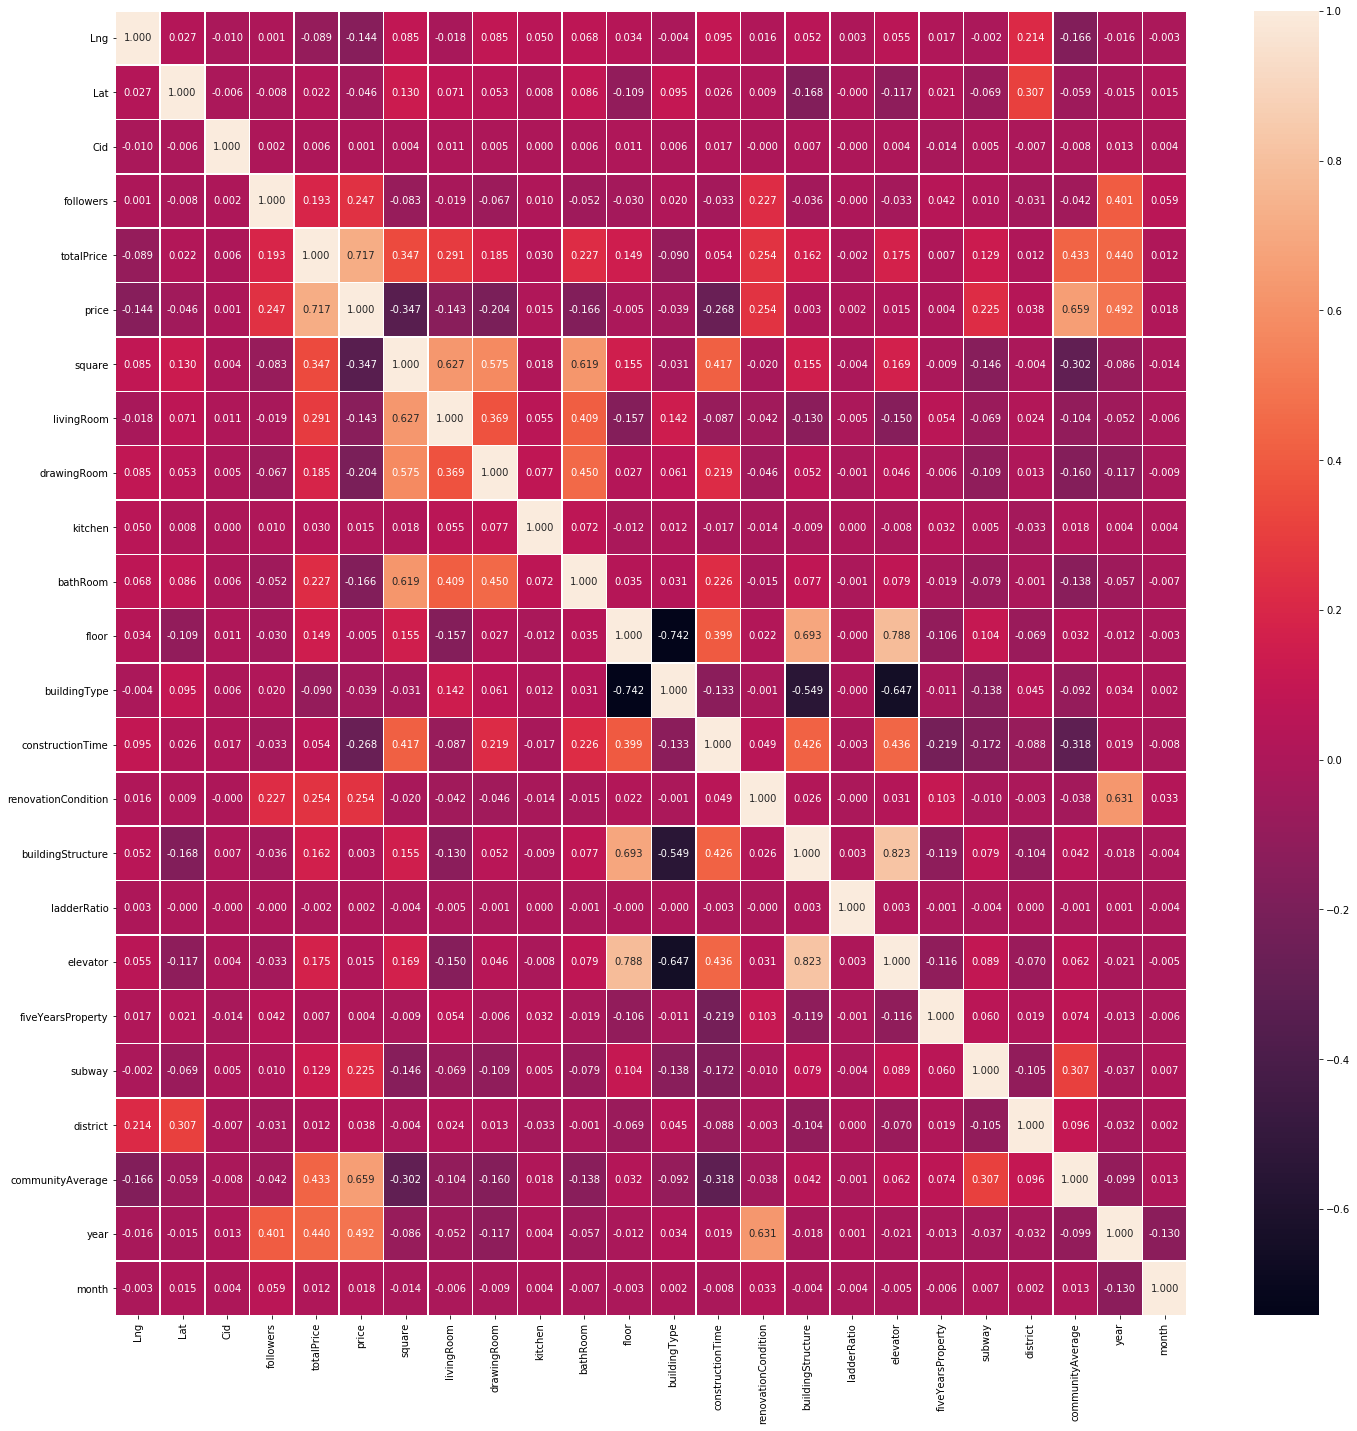

In [12]:
f,ax = plt.subplots(figsize=(24, 24))
sns.heatmap(df_train.corr(), annot = True, linewidth = .5, fmt = ".3f",ax = ax)
plt.show()

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206971 entries, 0 to 255080
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Lng                  206971 non-null  float64
 1   Lat                  206971 non-null  float64
 2   Cid                  206971 non-null  int64  
 3   followers            206971 non-null  int64  
 4   totalPrice           206971 non-null  float64
 5   price                206971 non-null  int64  
 6   square               206971 non-null  float64
 7   livingRoom           206971 non-null  int64  
 8   drawingRoom          206971 non-null  int64  
 9   kitchen              206971 non-null  int64  
 10  bathRoom             206971 non-null  int64  
 11  floor                206971 non-null  int64  
 12  buildingType         206971 non-null  float64
 13  constructionTime     206971 non-null  int64  
 14  renovationCondition  206971 non-null  int64  
 15  buildingStructure

In [14]:
df_test.drop(['url','id','DOM'],axis=1,inplace = True)#删除URL和id两列
df_test['tradeTime'] = pd.to_datetime(df_test['tradeTime'])
df_test['year'] = df_test['tradeTime'].dt.year#将交易时间的数据类型转为int
df_test['month'] = df_test['tradeTime'].dt.month#将交易时间的数据类型转为int
df_test.drop(['tradeTime'],axis=1,inplace = True) 
df_test['livingRoom'] = df_test['livingRoom'].str.extract(r'([0-9]+)')
df_test['livingRoom'].fillna(2, inplace=True)#用最多的值填充
df_test['livingRoom'] = df_test['livingRoom'].astype('int64')
df_test['drawingRoom'] = df_test['drawingRoom'].str.extract(r'([0-9]+)')
df_test['drawingRoom'].fillna(1, inplace=True)#用最多的值填充
df_test['drawingRoom'] = df_test['drawingRoom'].astype('int64')
df_test['floor'] = df_test['floor'].str.extract(r'([0-9]+)')
df_test['floor'] = df_test['floor'].astype('int64')
df_test['constructionTime'] = df_test['constructionTime'].str.extract(r'([0-9]+)')
df_test['constructionTime'].fillna(2004, inplace=True)#用最多的值填充
df_test['constructionTime'] = df_test['constructionTime'].astype('int64')
df_test.fillna(df_test.mean(), inplace=True)

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63770 entries, 0 to 63769
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Lng                  63770 non-null  float64
 1   Lat                  63770 non-null  float64
 2   Cid                  63770 non-null  float64
 3   followers            63770 non-null  int64  
 4   price                63770 non-null  int64  
 5   square               63770 non-null  float64
 6   livingRoom           63770 non-null  int64  
 7   drawingRoom          63770 non-null  int64  
 8   kitchen              63770 non-null  int64  
 9   bathRoom             63770 non-null  int64  
 10  floor                63770 non-null  int64  
 11  buildingType         63770 non-null  float64
 12  constructionTime     63770 non-null  int64  
 13  renovationCondition  63770 non-null  int64  
 14  buildingStructure    63770 non-null  int64  
 15  ladderRatio          63770 non-null 

In [16]:
from sklearn.model_selection import train_test_split,cross_val_score 
X = df_train.drop('totalPrice', axis = 1)
y = df_train['totalPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [17]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X,y)
print("十次交叉验证得到的最大分数score =",max(cross_val_score(lin_reg, X, y, cv=10)))

十次交叉验证得到的最大分数score = 0.9490913235430991


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)
pred = lin_reg.predict(X_test)
mae = metrics.mean_absolute_error(y_test, pred)
mse = metrics.mean_squared_error(y_test, pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
r2_square = metrics.r2_score(y_test, pred)
print("MAE = ",mae)
print("MSE = ",mse)
print("RMSE = ",rmse)
print("R2 = ",r2_square)

MAE =  26.8132389650104
MSE =  1435.5276297852033
RMSE =  37.88835744374785
R2 =  0.925751360501993


In [19]:
from sklearn import metrics
result = pd.DataFrame()
result =  pd.read_csv('result.txt',sep=" ")
result['pred'] = pd.DataFrame(lin_reg.predict(df_test))
result.dropna(subset=['totalPrice'], axis = 0, inplace = True)#删去有缺失值的行
result['totalPrice'] = result['totalPrice'].astype('float')
result['pred'] = result['pred'].astype('float')
mae = metrics.mean_absolute_error(result['totalPrice'], result['pred'])
mse = metrics.mean_squared_error(result['totalPrice'], result['pred'])
rmse = np.sqrt(metrics.mean_squared_error(result['totalPrice'], result['pred']))
r2_square = metrics.r2_score(result['totalPrice'], result['pred'])
print("MAE = ",mae)
print("MSE = ",mse)
print("RMSE = ",rmse)
print("R2 = ",r2_square)

MAE =  54.598910478573565
MSE =  409652.12147311325
RMSE =  640.0407186055535
R2 =  -6.515083876103187


In [20]:
df = pd.read_csv("test.csv", encoding='iso-8859-1', low_memory = False)
df['totalPrice'] = pd.DataFrame(lin_reg.predict(df_test))
df.to_csv('result.csv') 

In [21]:
print(result)

          id  totalPrice        pred
0          0       392.0  365.770942
2          2       285.0  291.648743
3          3       175.0  180.124168
4          4      1150.0  926.635419
5          5       630.0  593.582729
...      ...         ...         ...
45996  45996       165.0  166.776244
45997  45997       199.0  205.794674
45998  45998       326.0  341.082309
45999  45999       370.0  395.427796
46000  46000       210.0  236.911526

[43959 rows x 3 columns]
